In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW:
!pip install -Uqq fastbook
!pip install bing_image_downloader
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [3]:
#@ Downloading necesaaries dependencies:
from bing_image_downloader import downloader
import os, shutil
from pathlib import Path
from fastai.vision.all import *

In [4]:
dataset_name='bears'
path=Path(dataset_name)

In [5]:
if not path.exists():
  path.mkdir()

In [6]:
labels=['grizzly', 'black', 'teddy']

In [7]:
for l in labels:
  downloader.download(query=f'{l} bear', limit=100, output_dir=path, adult_filter_off=True)

[%] Downloading Images to /content/bears/grizzly bear


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg
[Error]Invalid image, not saving https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg

[!] Issue getting: https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg
[!] Error:: Invalid image, not saving https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg

[%] Downloading Image #2 from https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains-Wyoming.jpg
[Error]Invalid image, not saving https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains-Wyoming.jpg

[!] Issue getting: https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains

In [8]:
fname=get_image_files(path)
fname

(#298) [Path('bears/grizzly bear/Image_86.jpg'),Path('bears/grizzly bear/Image_43.jpg'),Path('bears/grizzly bear/Image_69.jpg'),Path('bears/grizzly bear/Image_9.jpg'),Path('bears/grizzly bear/Image_97.jpg'),Path('bears/grizzly bear/Image_31.jpg'),Path('bears/grizzly bear/Image_38.jpg'),Path('bears/grizzly bear/Image_78.jpg'),Path('bears/grizzly bear/Image_77.jpg'),Path('bears/grizzly bear/Image_89.jpg')...]

In [9]:
#@ Checking for the corrupted oness:
failed=verify_images(fname)
len(failed)
failed.map(Path.unlink);

In [10]:
#@ Dataloaders:
bears=DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls=bears.dataloaders(path)

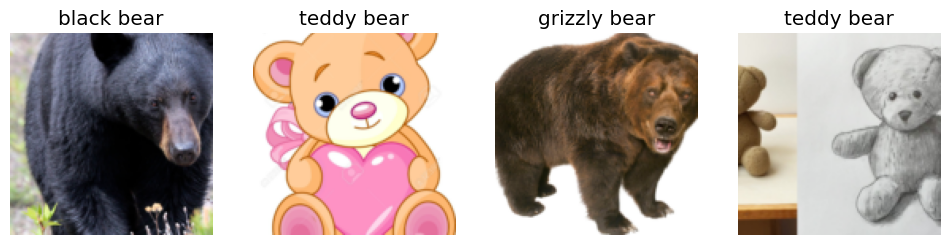

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

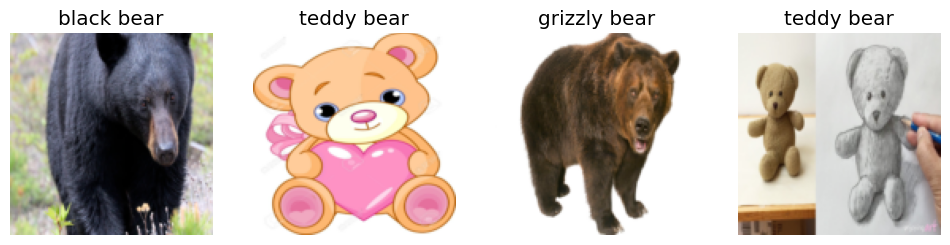

In [12]:
#@ Padding the images to stretch the lost part:
bears=bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

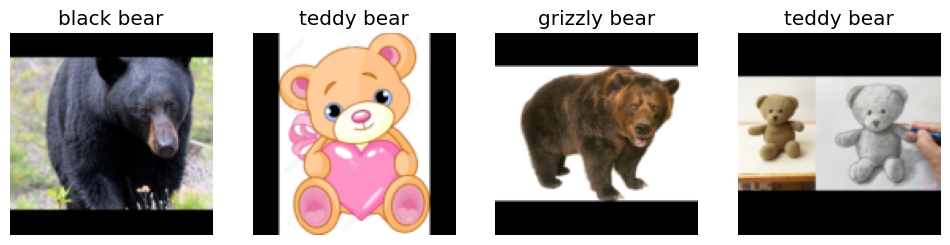

In [13]:
#@ Another approach:
bears=bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

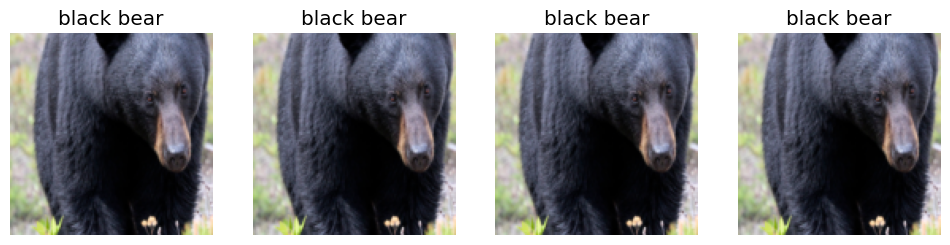

In [14]:
#@ Kind of Data augmentation:
bears=bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

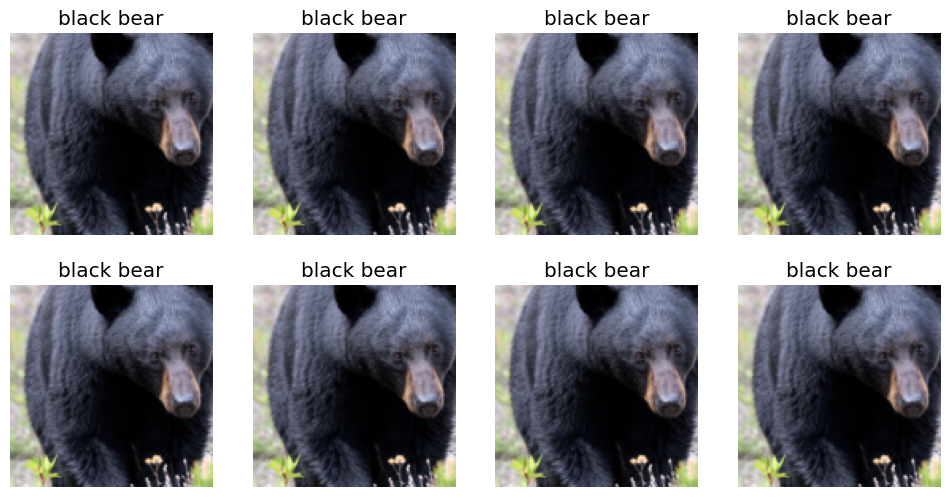

In [15]:
bears=bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

#### Training the model and using it for cleaning data

In [16]:
bears=bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls=bears.dataloaders(path)

In [19]:
#@ Training and fine-tuning:
learn=vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


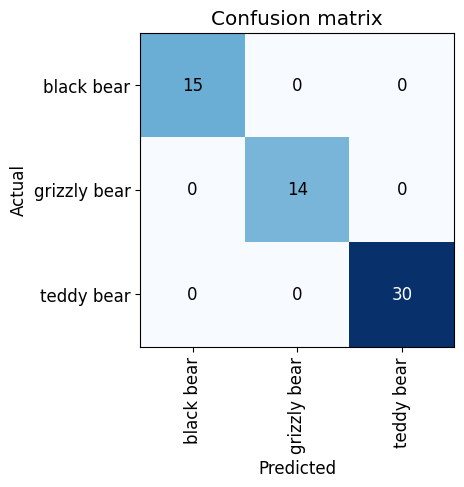

In [20]:
#@ Confusion Matrix:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

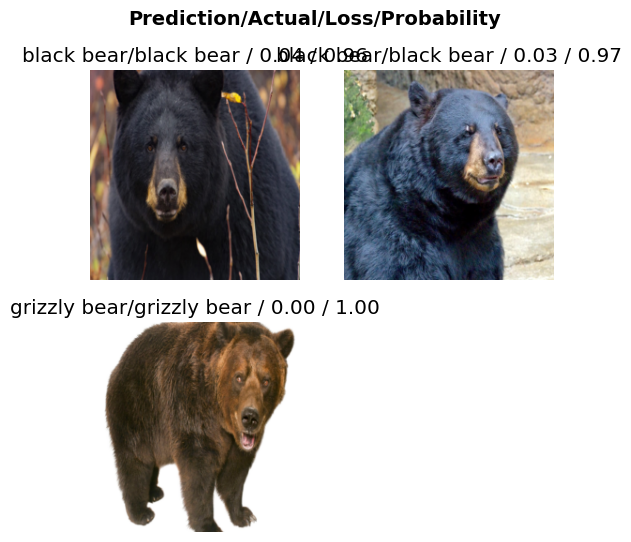

In [24]:
#@ Calculating top loss:
interp.plot_top_losses(3, nrows=2)

In [26]:
#@ Cleaning:
from fastai.vision.widgets import *
cleaner=ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [27]:
#@ For deletion:
for idx in cleaner.delete():
  cleaner.fname[idx].unlink()

#@ For Moving to selected categories:
for idx, cat in cleaner.change():
  shutil.move(str(cleaner.fname[idx]), path/cat)

In [28]:
#@ Saving model:
learn.export()

In [29]:
#@ Checking if model is saved:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
#@ Getting Inference:
learn_inf=load_learner(path/'export.pkl')

In [35]:
#@ Prediction:
learn_inf.predict('bears/grizzly bear/Image_1.jpg')

('grizzly bear', tensor(1), tensor([8.8700e-07, 1.0000e+00, 2.0273e-06]))

In [36]:
learn_inf.dls.vocab

['black bear', 'grizzly bear', 'teddy bear']

# Deployment

In [41]:
#@ Creating Upload button using IPYTHON Widgets:
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [42]:
img=PILImage.create(btn_upload.data[-1])

In [43]:
#@ for displaying:
out_pl=widgets.Output()
out_pl.clear_output()
with out_pl:
  display(img.to_thumb(128, 128))
out_pl

Output()

In [44]:
#@ predictions and labeling for display:
pred, pred_idx, probs=learn_inf.predict(img)

# for labeling:
lbl_pred=widgets.Label()
lbl_pred.value=f'Prediction: {pred}; Probability:{probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black bear; Probability:0.9996')

In [45]:
#@ Classification button:
btn_classify=widgets.Button(description='Classify')
btn_classify

Button(description='Classify', style=ButtonStyle())

In [46]:
#@ Creating click event handler:

def on_click_classify(change):
  img=PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:
    display(img.to_thumb(128,128))
  pred, pred_idx, probs=learn_inf.predict(img)
  lbl_pred.value=f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_classify.on_click(on_click_classify)

In [48]:
#@ Testing:
VBox([widgets.Label('Select Image of a bear!!'),
      btn_upload, btn_classify, out_pl, lbl_pred])